<a href="https://colab.research.google.com/github/sailkargutkar/Python-Projects/blob/HELBNTODR100395/HELBNTODR100395.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [97]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import collections
import re
import string
import nltk 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score

In [25]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
data = pd.read_csv('/content/agr_en_train.csv', header = None)

In [13]:
data.columns = ['Id','Text', 'Label']

In [14]:
data.head()

,Id,Text,Label
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [15]:
data.Label.unique()

array(['OAG', 'NAG', 'CAG'], dtype=object)

In [16]:
data.shape

(11999, 3)

In [17]:
nag = []
cag = []
oag = []
for l in data.Label:
    if l == 'CAG':
        oag.append(0)
        nag.append(0)
        cag.append(1)
    elif l == 'NAG':
        oag.append(0)
        nag.append(1)
        cag.append(0)
    elif l == 'OAG':
        oag.append(1)
        nag.append(0)
        cag.append(0)

In [18]:
data['CAG']= nag
data['NAG']= oag
data['OAG']= cag

In [20]:
data.head()

,Id,Text,Label,CAG,NAG,OAG
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG,0,1,0
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG,1,0,0
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG,0,1,0
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG,0,1,0
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG,1,0,0


**Clean data**

In [21]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [26]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [27]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [28]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [29]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [30]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [31]:
result = [' '.join(sen) for sen in filtered_words]

In [32]:
data['Text_Final'] = result

In [33]:
data['tokens'] = filtered_words

In [34]:
data = data[['Text_Final', 'tokens', 'Label', 'NAG', 'CAG','OAG']]

In [35]:
data[:4]

,Text_Final,tokens,Label,NAG,CAG,OAG
0,well said sonuyou courage stand dadagiri muslims,"[well, said, sonuyou, courage, stand, dadagiri...",OAG,1,0,0
1,private banks atms like hdfc icici etc cash pu...,"[private, banks, atms, like, hdfc, icici, etc,...",NAG,0,1,0
2,question pakistan adhere,"[question, pakistan, adhere]",OAG,1,0,0
3,pakistan comprised fake muslims know meaning u...,"[pakistan, comprised, fake, muslims, know, mea...",OAG,1,0,0


**Split data into test and train**

In [36]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [37]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

155952 words total, with a vocabulary size of 24229
Max sentence length is 666


**Load Google News Word2Vec model**


In [39]:
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [40]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

**Get Embeddings**

In [41]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [42]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

**Tokenize and Pad sequences**

In [43]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 24227 unique tokens.


In [45]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [46]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(24228, 300)


In [47]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

**Define CNN**

In [49]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [50]:
label_names = ['CAG', 'NAG','OAG']

In [51]:
y_train = data_train[label_names].values

In [52]:
x_train = train_cnn_data
y_tr = y_train

In [53]:
len(list(label_names))

3

In [54]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      7268400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 200)      120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 200)      180200      embedding_1[0][0]                
____________________________________________________________________________________________

In [55]:
num_epochs = 3
batch_size = 34

In [56]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 9719 samples, validate on 1080 samples
Epoch 1/3
9719/9719 [==============================] - 51s 5ms/step - loss: 1.0603 - acc: 0.4320 - val_loss: 1.0340 - val_acc: 0.5056
Epoch 2/3
9719/9719 [==============================] - 51s 5ms/step - loss: 0.9854 - acc: 0.4976 - val_loss: 0.9773 - val_acc: 0.5269
Epoch 3/3
9719/9719 [==============================] - 50s 5ms/step - loss: 0.8527 - acc: 0.5770 - val_loss: 0.9242 - val_acc: 0.5630


**Test CNN**

In [57]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1200/1200 [==============================] - 2s 2ms/step


**Loss & Accuracy visualization graph**

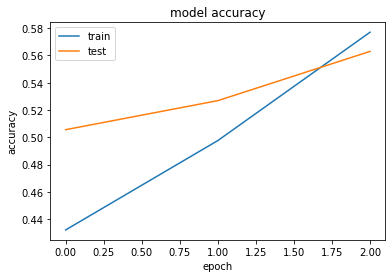

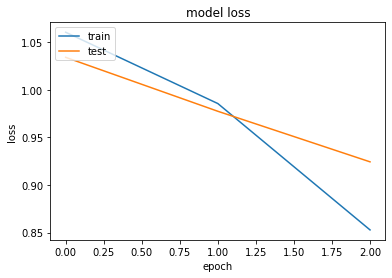

In [100]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Evaluate CNN**

In [81]:
x_test = test_cnn_data

In [82]:
label_names = ['CAG', 'NAG','OAG']

In [84]:
y_test = data_test[label_names].values

In [85]:
x_test.shape

(1200, 50)

In [86]:
y_test.shape

(1200, 3)

In [87]:
evaluation = model.evaluate(x_test,y_test)

1200/1200 [==============================] - 2s 2ms/step


**Printing F1 score**

In [89]:
predictions_x_value = np.argmax(y_test, axis=1)
predictions_y_value = np.argmax(predictions, axis=1)

In [93]:
f1_score(predictions_x_value,predictions_y_value,average="micro")

0.5566666666666666

**Printing confusion matrix**

In [94]:
print(confusion_matrix(predictions_x_value,predictions_y_value))

[[380  51  82]
 [ 52 125  66]
 [179 102 163]]
